# Supervised learning

In this notebook, we train a model to predict all the variables that explain the quality of the weld, as yield strength alone is not a very good indicator.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Reading of the train and test sets defined in 3-scaling
df_train = pd.read_csv("../data/train_normalised.csv")
df_test = pd.read_csv("../data/test_normalised.csv")


For supervised learning, we will only keep labelled data, which is what is done in the following part

In [2]:
target = ["YieldStrength","UTS","Elongation","ReductionArea","CharpyTemp","CharpyImpact","Hardness","FATT50"]

# Definition of X_train and y_train
X_train = df_train.drop(columns=target)
y_train = df_train[target]

X_test  = df_test.drop(columns=target)
y_test  = df_test[target]

# Drop columns with more than 90% NaN in X_train
nan_ratio = X_train.isna().mean()
cols_to_drop = nan_ratio[nan_ratio > 0.9].index
X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)

print(f"Dropped columns with >90% NaN: {list(cols_to_drop)}")

# For each target, create labelled data where that target is not NaN
X_train_labelled = {}
y_train_labelled = {}
for tgt in target:
    mask = y_train[tgt].notna()
    X_train_labelled[tgt] = X_train.loc[mask].copy()
    y_train_labelled[tgt] = y_train.loc[mask, tgt].copy()

Dropped columns with >90% NaN: ['PrimaryFerrite', 'Ferrite2ndPhase', 'AcicularFerrite', 'Martensite', 'FerriteCarbide']


We will here test 2 different supervised learning method for each target separately: 
* **Random Forest Regressor**
* **Gradient Boosting Regressor**

We will evaluate their performance based on :
* **Graphs** : How close the predicted values are to the observed values for each target; 
* **R²** : the closest to 1, the better the model, as it means that the model encapsulate the variance well
* **Mean Squared Error** : the smaller the better, as it will mean that great errors rarely exist
* **Mean Absolute Error** : the smaller the better, it shows how close the model predicts the target

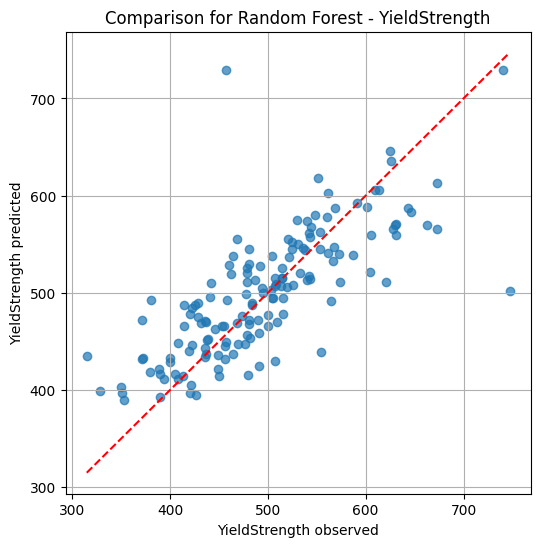

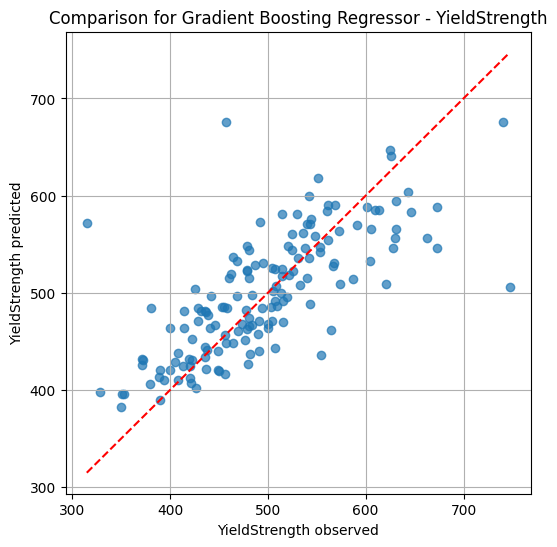

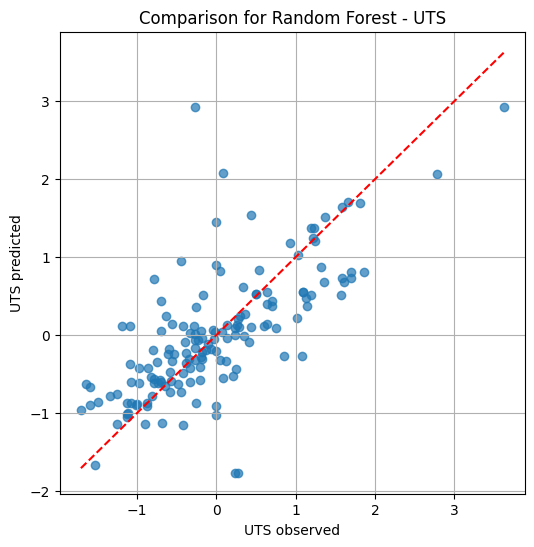

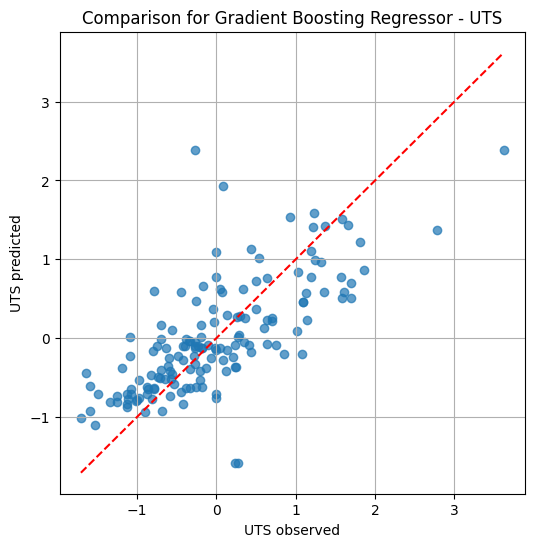

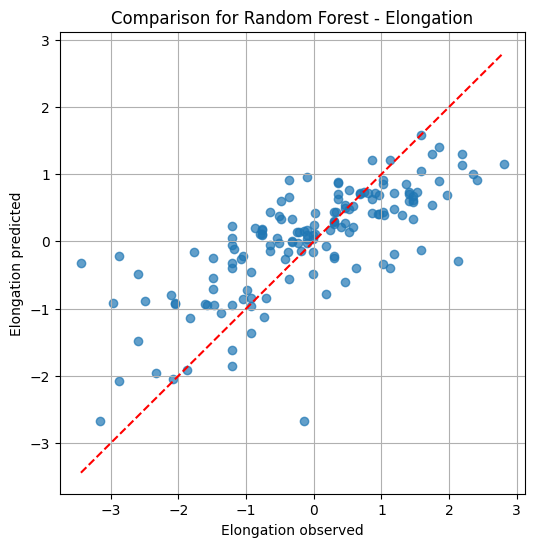

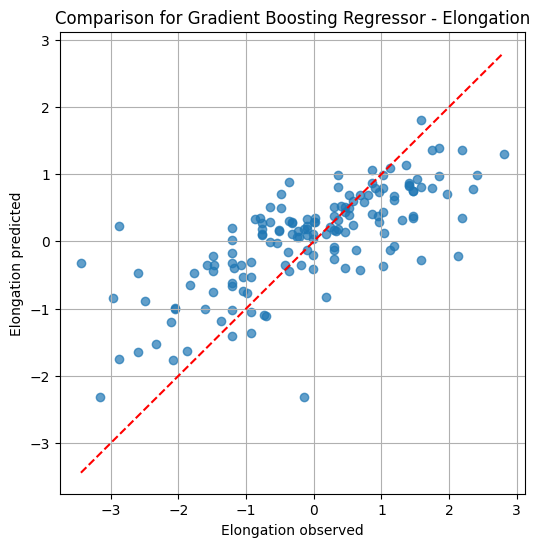

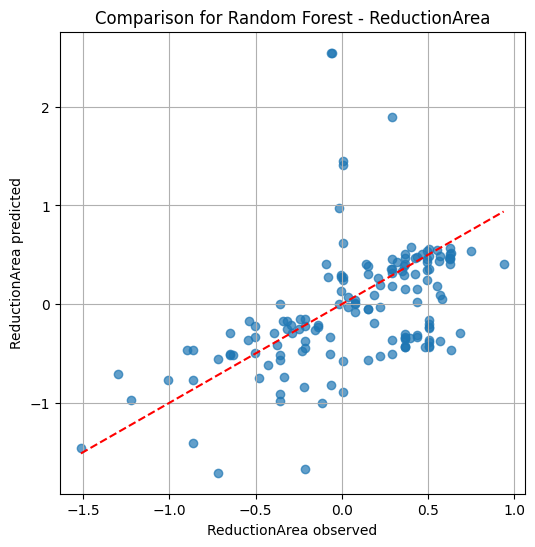

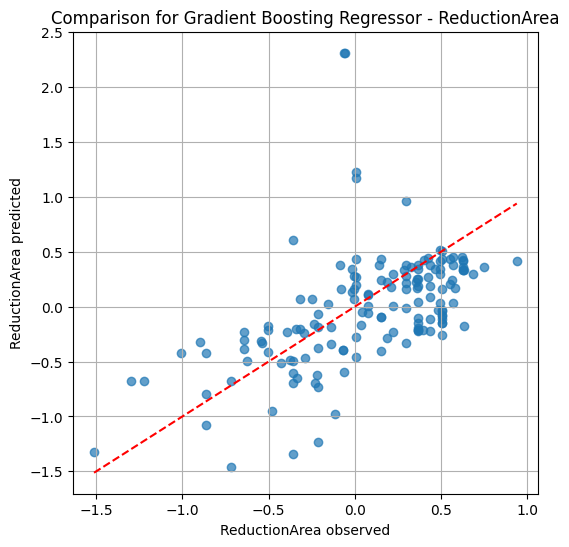

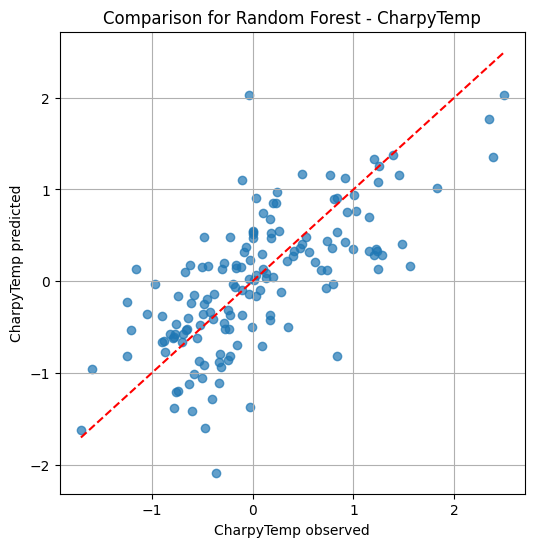

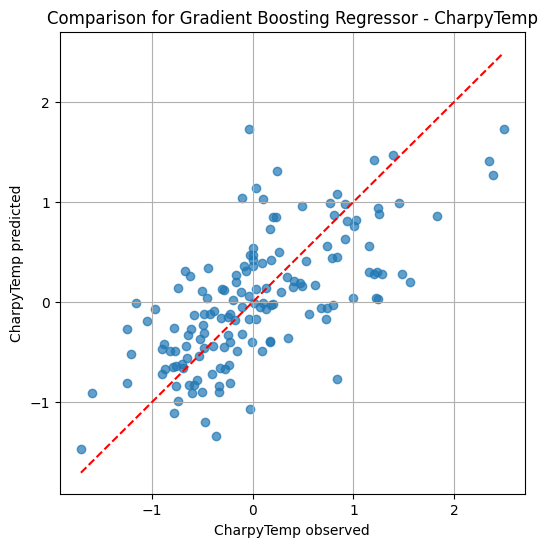

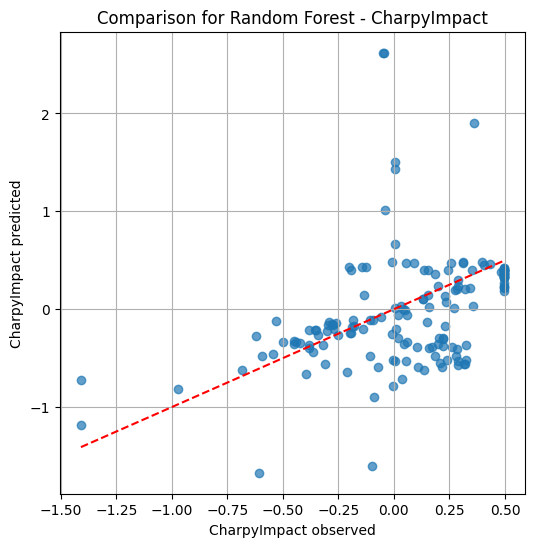

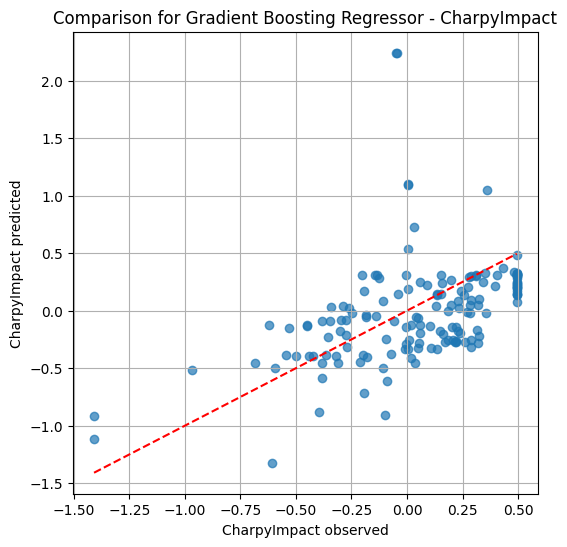

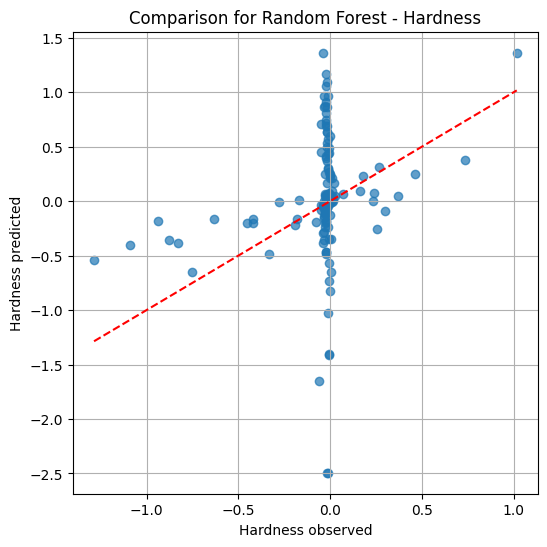

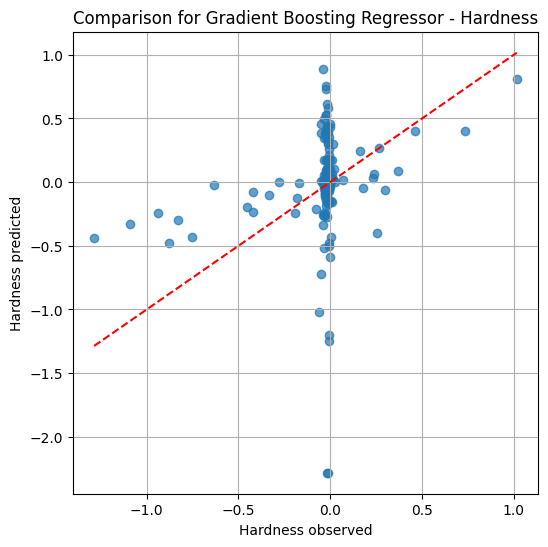

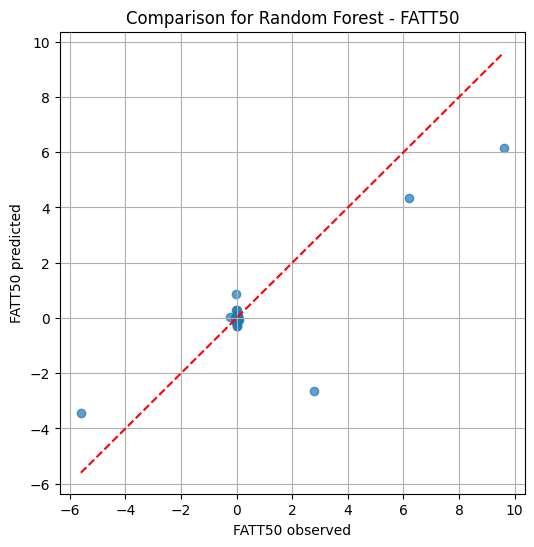

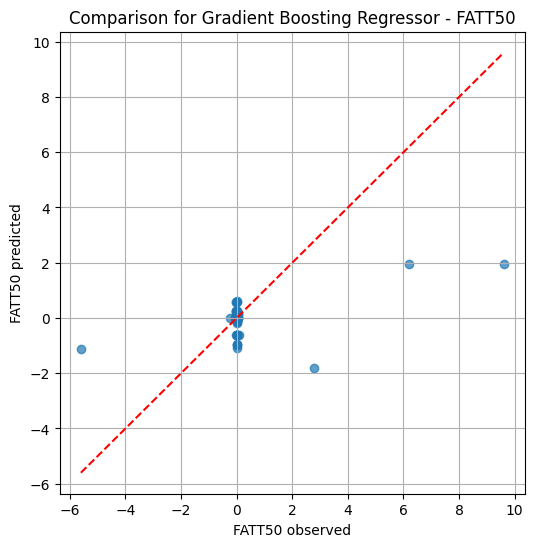

Target                           CharpyImpact  CharpyTemp  Elongation  \
    Model                                                               
MAE Gradient Boosting Regressor      0.304643    0.456655    0.680158   
    Random Forest                    0.351009    0.465283    0.665048   
MSE Gradient Boosting Regressor      0.427291    0.576989    0.890984   
    Random Forest                    0.548083    0.595142    0.877713   
R²  Gradient Boosting Regressor     -0.422382    0.443018    0.510345   
    Random Forest                   -1.340243    0.407420    0.524824   

Target                             FATT50  Hardness  ReductionArea       UTS  \
    Model                                                                      
MAE Gradient Boosting Regressor  0.237191  0.259772       0.345004  0.484353   
    Random Forest                0.121163  0.339229       0.385274  0.457043   
MSE Gradient Boosting Regressor  0.911487  0.425858       0.483584  0.637925   
    Random Forest                0.579405  0.545977       0.576813  0.660624   
R²  Gradient Boosting Regressor  0.250276 -2.035754      -0.120611  0.510362   
    Random Forest                0.697054 -3.989815      -0.594341  0.474898   

Target                           YieldStrength  
    Model                                       
MAE Gradient Boosting Regressor      39.263728  
    Random Forest                    36.930121  
MSE Gradient Boosting Regressor      55.131290  
    Random Forest                    52.397857  
R²  Gradient Boosting Regressor       0.522849  
    Random Forest                     0.568990

In [3]:
models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=300, 
        random_state=42
        ),
    "Gradient Boosting Regressor": HistGradientBoostingRegressor(
        learning_rate=0.1, 
        max_iter=300, 
        max_depth=6, 
        min_samples_leaf=20,
        l2_regularization=0.1,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
        )
}

results = {}
for tgt in target:
    results[tgt] = {}
    for name, model in models.items():
        model.fit(X_train_labelled[tgt], y_train_labelled[tgt])
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test[tgt], y_pred)
        rmse = np.sqrt(mean_squared_error(y_test[tgt], y_pred))
        r2 = r2_score(y_test[tgt], y_pred)
        results[tgt][name] = {"MAE": mae, "MSE": rmse, "R²": r2}
        plt.figure(figsize=(6,6))
        plt.scatter(y_test[tgt], y_pred, alpha=0.7)
        plt.plot([y_test[tgt].min(), y_test[tgt].max()], [y_test[tgt].min(), y_test[tgt].max()], 'r--')
        plt.xlabel(f"{tgt} observed")
        plt.ylabel(f"{tgt} predicted")
        plt.title(f"Comparison for {name} - {tgt}")
        plt.grid(True)
        plt.show()

# Display results as DataFrame
import pandas as pd
all_results = []
for tgt, model_results in results.items():
    for model, metrics in model_results.items():
        all_results.append({"Target": tgt, "Model": model, **metrics})
pd.DataFrame(all_results).pivot(index="Target", columns="Model", values=["MAE", "MSE", "R²"]).T

Fine-tuning of the two models, to try and better the results :

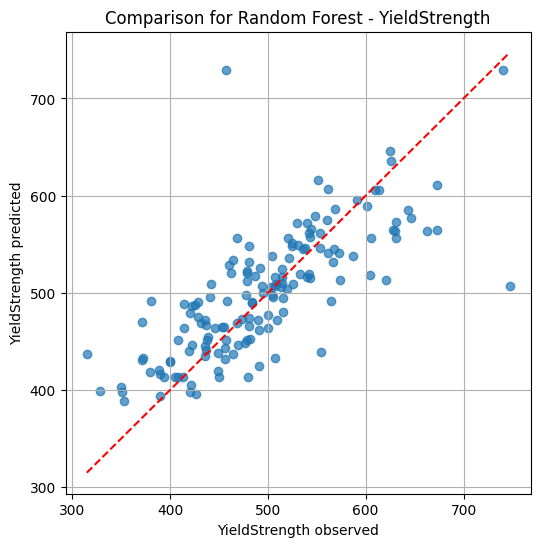

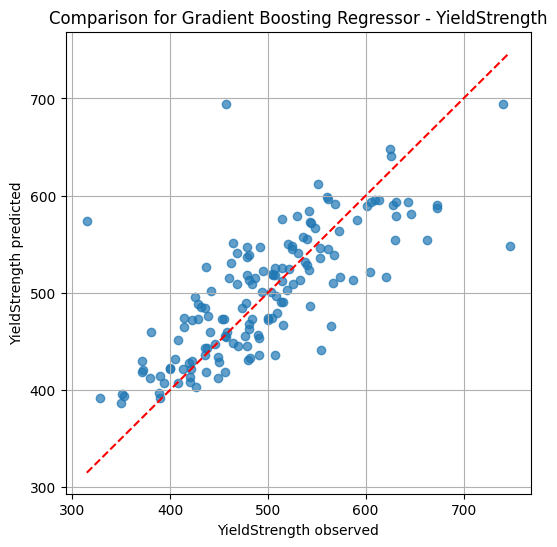

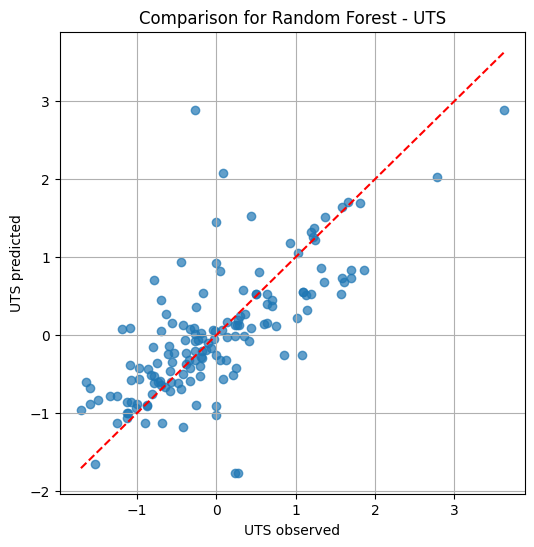

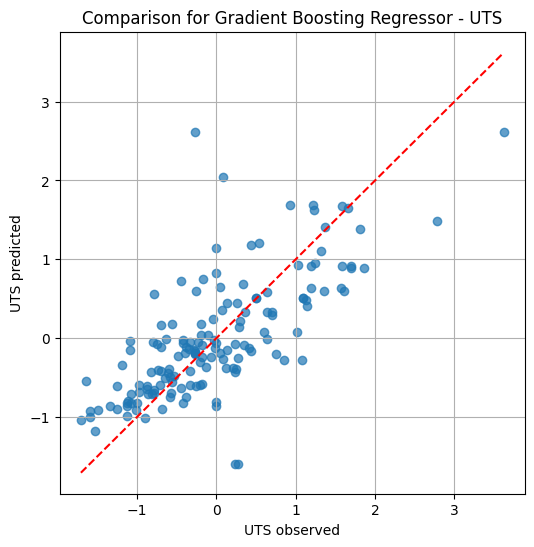

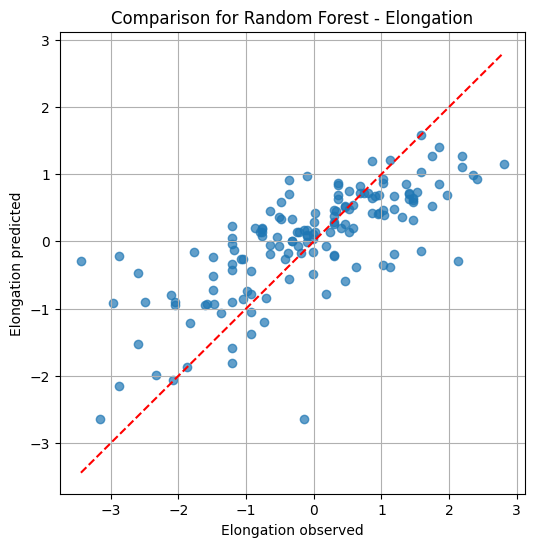

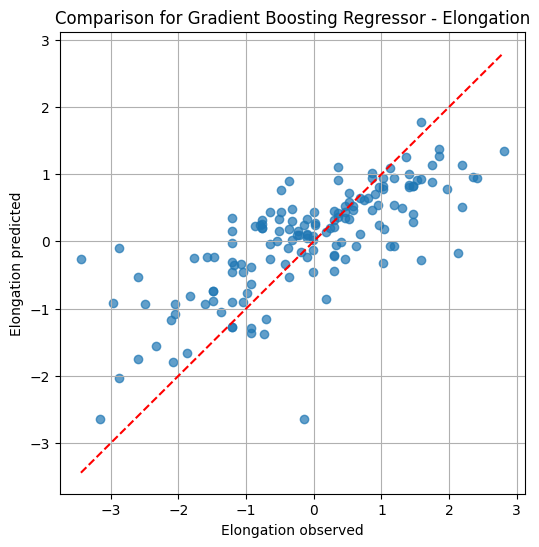

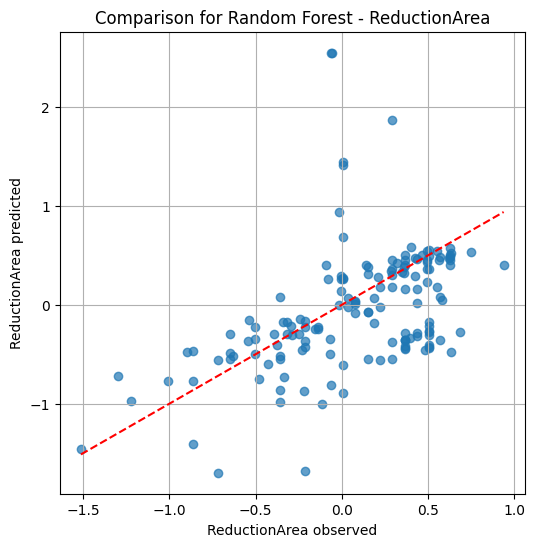

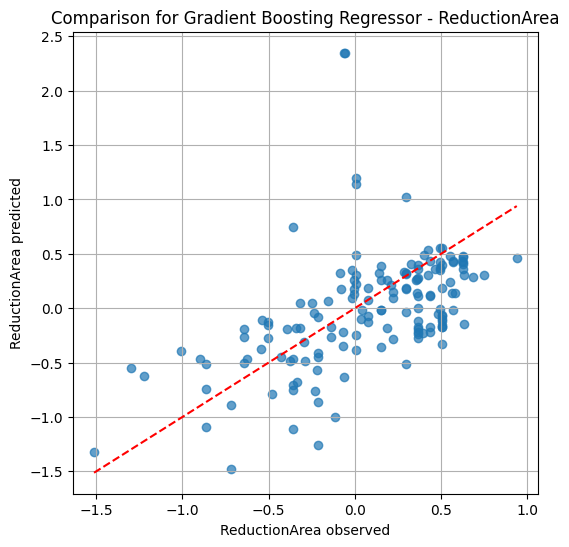

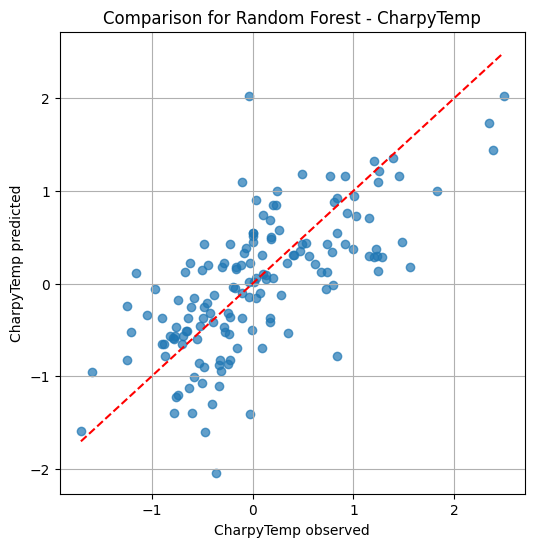

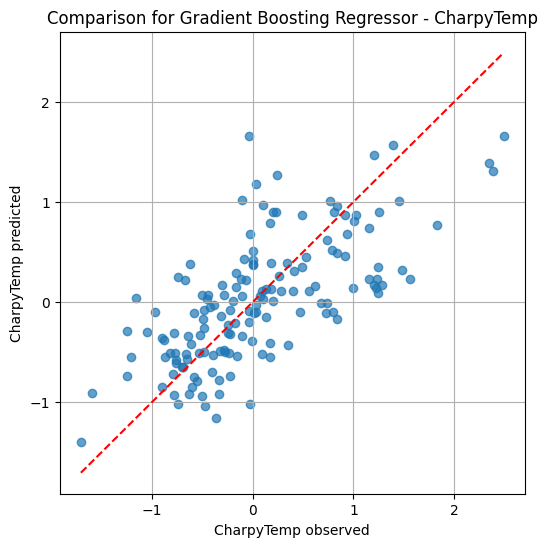

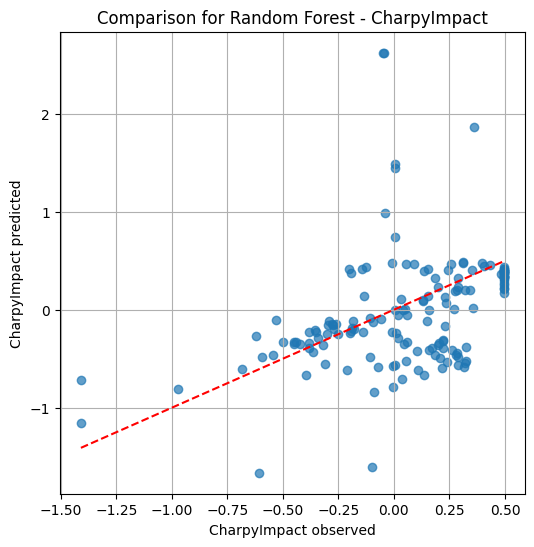

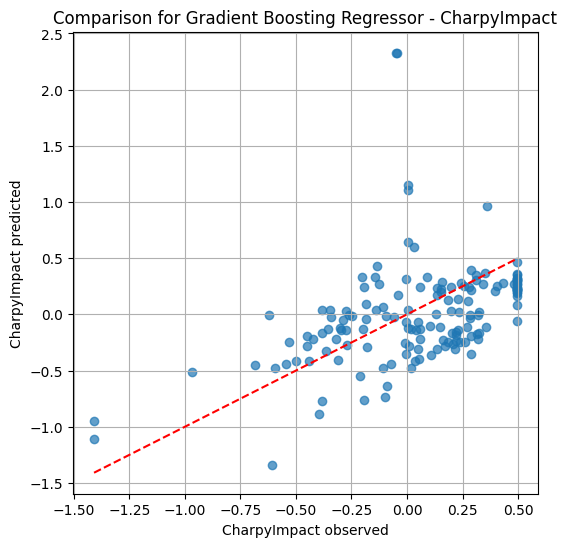

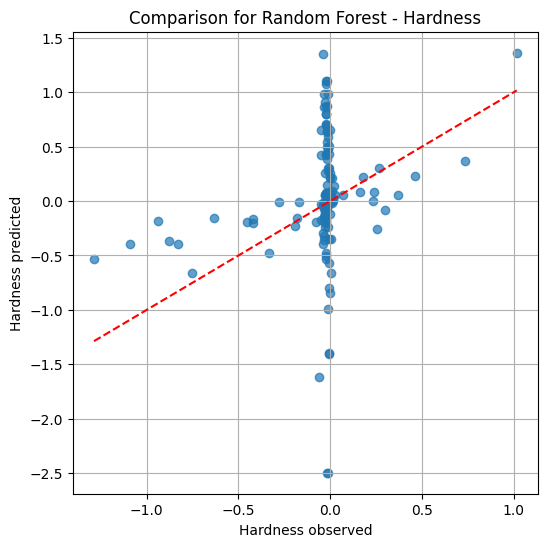

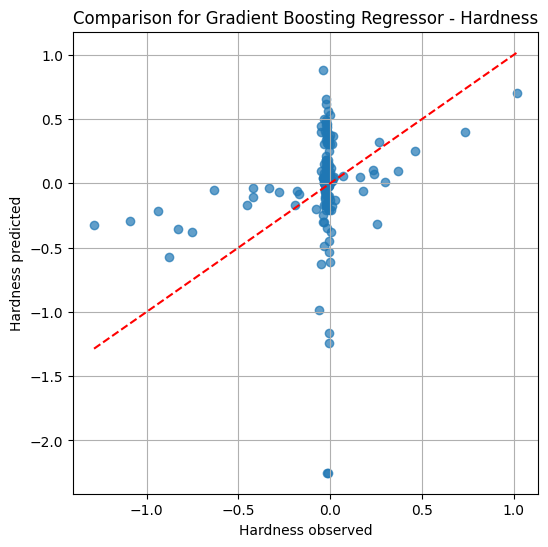

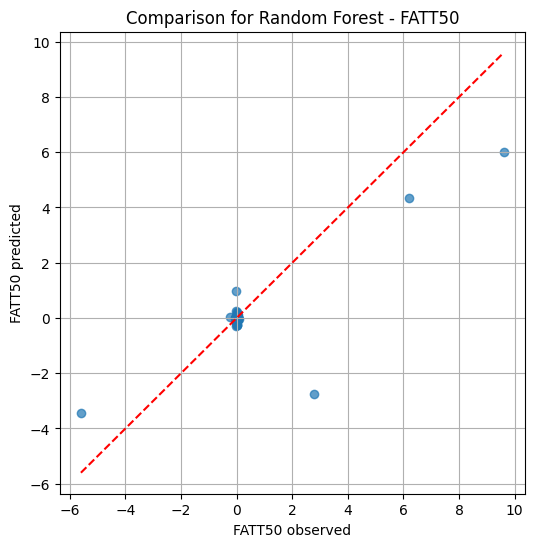

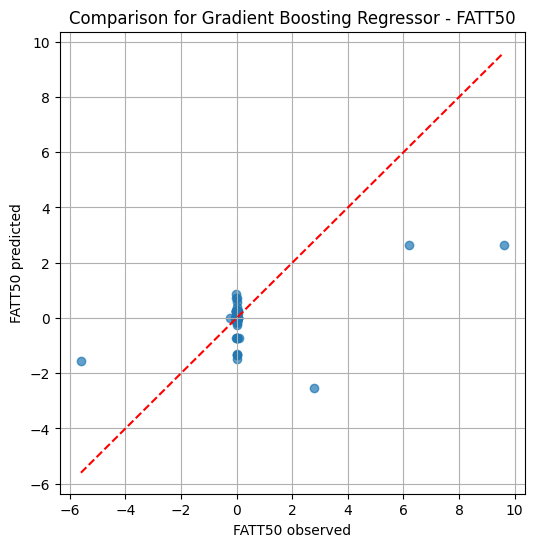

Target                           CharpyImpact  CharpyTemp  Elongation  \
    Model                                                               
MAE Gradient Boosting Regressor      0.311791    0.445069    0.659638   
    Random Forest                    0.353333    0.467309    0.668297   
MSE Gradient Boosting Regressor      0.437771    0.565860    0.872484   
    Random Forest                    0.548779    0.594063    0.879076   
R²  Gradient Boosting Regressor     -0.493010    0.464298    0.530468   
    Random Forest                   -1.346192    0.409567    0.523346   

Target                             FATT50  Hardness  ReductionArea       UTS  \
    Model                                                                      
MAE Gradient Boosting Regressor  0.255968  0.266559       0.353225  0.474000   
    Random Forest                0.124557  0.341707       0.385953  0.456606   
MSE Gradient Boosting Regressor  0.887319  0.421236       0.494020  0.636991   
    Random Forest                0.591622  0.547153       0.578035  0.659691   
R²  Gradient Boosting Regressor  0.289507 -1.970209      -0.169503  0.511794   
    Random Forest                0.684145 -4.011345      -0.601103  0.476379   

Target                           YieldStrength  
    Model                                       
MAE Gradient Boosting Regressor      37.776481  
    Random Forest                    37.058655  
MSE Gradient Boosting Regressor      53.086990  
    Random Forest                    52.429866  
R²  Gradient Boosting Regressor       0.557579  
    Random Forest                     0.568464

In [4]:
models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=200, # Testing with less trees : increases rapidity, but maintains stability while bettering the results 
        random_state=42
        ),
    "Gradient Boosting Regressor": HistGradientBoostingRegressor(
        learning_rate=0.15, # Increasing the learning rate
        max_iter=600, # Increasing the number of iterations
        max_depth=5, 
        min_samples_leaf=20,
        l2_regularization=0.1,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
        )
}

results = {}
for tgt in target:
    results[tgt] = {}
    for name, model in models.items():
        model.fit(X_train_labelled[tgt], y_train_labelled[tgt])
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test[tgt], y_pred)
        rmse = np.sqrt(mean_squared_error(y_test[tgt], y_pred))
        r2 = r2_score(y_test[tgt], y_pred)
        results[tgt][name] = {"MAE": mae, "MSE": rmse, "R²": r2}
        plt.figure(figsize=(6,6))
        plt.scatter(y_test[tgt], y_pred, alpha=0.7)
        plt.plot([y_test[tgt].min(), y_test[tgt].max()], [y_test[tgt].min(), y_test[tgt].max()], 'r--')
        plt.xlabel(f"{tgt} observed")
        plt.ylabel(f"{tgt} predicted")
        plt.title(f"Comparison for {name} - {tgt}")
        plt.grid(True)
        plt.show()

# Display results as DataFrame
import pandas as pd
all_results = []
for tgt, model_results in results.items():
    for model, metrics in model_results.items():
        all_results.append({"Target": tgt, "Model": model, **metrics})
pd.DataFrame(all_results).pivot(index="Target", columns="Model", values=["MAE", "MSE", "R²"]).T